## Intro

Here, we will see the extrapolation potential - and problems - of neural networks. We have trained two simple networsk with one, 8-neuron hidden layer, to imitate the transformation  $x + 10$ on the dataset $x ~ N(0, 1)$. We'll see how well they perform outside that domain. (The only difference between them is the nonlinearity - one ELU, one ReLU).

In [1]:
from utils import *
from simple import *
from func import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'step8'

hidden=8
datasize, learning_rate, epochs = get_params(fname)
print([datasize, learning_rate, epochs])

Le, Lre = get_losses(fname)

e, re = get_models(fname)

datasize,learning_rate,epochs

[2048, 0.001, 50000]


## Learning

First, let's take a look at the learning curves, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

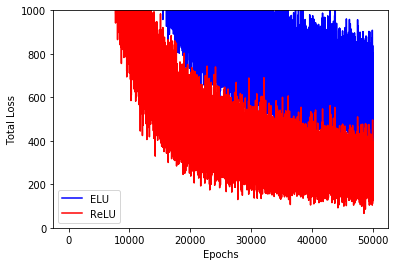

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(Le)+1), Le, 'b-', label="ELU")
plt.plot(range(1, len(Le)+1), Lre, 'r-', label="ReLU")
plt.ylim([0, 1000])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend()

fig

It appears that both losses have plateaued. Where?

In [3]:
print("ELU")
print(Le[-10:])
print("ReLU")
print(Lre[-10:])

ELU
[536.1355590820312, 642.1276245117188, 762.8154296875, 583.9918212890625, 553.0458984375, 609.5487060546875, 684.1654052734375, 389.56744384765625, 568.80078125, 654.685302734375]
ReLU
[175.6216278076172, 258.988037109375, 325.4085693359375, 219.6232147216797, 227.84103393554688, 225.33119201660156, 292.6573181152344, 126.45735168457031, 217.24713134765625, 236.8533172607422]


Great. Now, let's examin the behavior far from the training distribution

## Plots of The Function

In [4]:
# Get data and ground truth

x = np.arange(-2, 2, 0.001)
y = step(x)

In [5]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

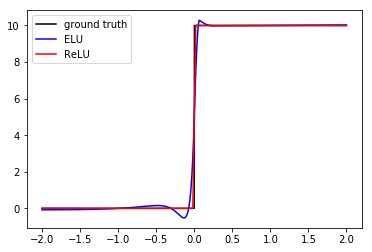

In [6]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

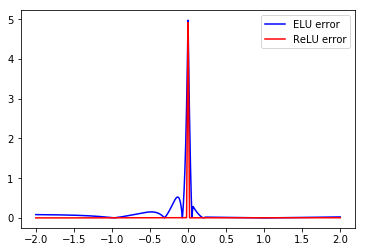

In [9]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(4000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(4000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

It seems that, with $25$ free parameters, we get low error everywhere except at the origin, especially for the ReLU network (the ELU network, due to its bias towards smooth functions, seems to have some high frequency "ringing").

Now, how well does a polynomial of the same degree perform?

In [39]:
#The fit

import numpy as np
import sklearn as skl 
from sklearn.preprocessing import PolynomialFeatures
from numpy.linalg import lstsq

xlonger = np.random.randn(100*datasize, 1)
ylonger = step(xlonger)

o25 = PolynomialFeatures(25)
x25longer = o25.fit_transform(xlonger.reshape(-1, 1))
x25 = o25.fit_transform(x.reshape(-1, 1))

params25, _, _, _ = lstsq(x25longer, ylonger)
#params25, _, _, _ = lstsq(x25, y)

#y25longer = np.matmul(x25longer, params25)
#y25 = y25longer[2999:-3001]

y25 = np.matmul(x25, params25)

/nfs01/shared_software/anaconda3/envs/artem/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


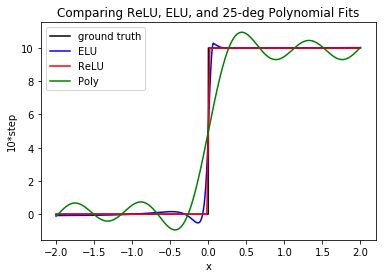

In [44]:
# Plotting

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")
plt.plot(x, y25, 'g-', label="Poly")

plt.title("Comparing ReLU, ELU, and 25-deg Polynomial Fits")
plt.xlabel("x")
plt.ylabel("10*step")

plt.legend()

fig

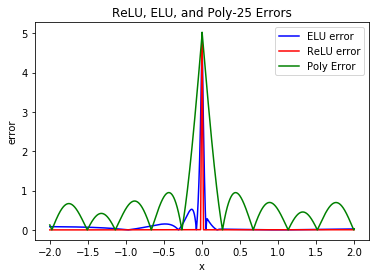

In [45]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(4000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(4000)-y)**2), 'r-', label="ReLU error")
plt.plot(x, np.sqrt((y25.reshape(4000)-y)**2), 'g-', label="Poly Error")

plt.title("ReLU, ELU, and Poly-25 Errors")
plt.xlabel("x")
plt.ylabel("error")

plt.legend()

fig

## Conclusion

Here, we see the advantage of using NNs at all - with the same exact number of free parameters, trained on the same distribution of values, both the ELU and the ReLU network had far, far lower errors on the training domain. The structure of the network is far more flexible, and it is capable of accomodating many different local regimes without tediously creating a table of all the diferent behaviors.